In [30]:
import numpy as np
import pandas as pd
import copy, math

import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
# df = pd.read_csv('./data/COVID-19_Case_Surveillance_Public_Use_Data.csv')

# size = 10000
# sample = df.sample(n = size, replace = True)
# sample.reset_index(drop = True, inplace = True)
# sample.to_csv('./data/sample_covid_data.csv')

sample = pd.read_csv('./data/sample_covid_data.csv')

In [32]:
sample.drop(labels = ['Unnamed: 0'], axis = 1, inplace = True)
sample.head()

,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
0,2022/11/27,2022/11/28,2022/11/27,NaN,Laboratory-confirmed case,Female,20 - 29 Years,Unknown,No,Missing,No,Missing
1,2022/02/01,2022/02/03,2022/02/01,NaN,Laboratory-confirmed case,Female,40 - 49 Years,"White, Non-Hispanic",No,Missing,No,Missing
2,2022/07/21,2022/07/21,NaN,NaN,Probable Case,Female,10 - 19 Years,"White, Non-Hispanic",Unknown,Missing,Missing,Missing
3,2021/08/07,2022/01/13,NaN,NaN,Laboratory-confirmed case,Male,0 - 9 Years,Hispanic/Latino,Missing,Missing,Missing,Missing
4,2022/02/08,2022/02/22,2022/02/10,2022/02/08,Probable Case,Male,40 - 49 Years,"White, Non-Hispanic",No,Missing,Unknown,No


In [33]:
sample.current_status.value_counts()

Laboratory-confirmed case    8318
Probable Case                1682
Name: current_status, dtype: int64

In [34]:
sample.age_group.value_counts()

20 - 29 Years    1721
30 - 39 Years    1634
50 - 59 Years    1346
40 - 49 Years    1336
10 - 19 Years    1221
60 - 69 Years     992
0 - 9 Years       774
70 - 79 Years     551
80+ Years         344
Missing            81
Name: age_group, dtype: int64

In [35]:
sample.age_group = sample.age_group.replace({'20 - 29 Years': 25, '30 - 39 Years': 35, '40 - 49 Years': 45,
                                             '50 - 59 Years': 55, '10 - 19 Years': 15, '60 - 69 Years': 65,
                                             '70 - 79 Years': 75, '0 - 9 Years': 5, '80+ Years': 85, 'Missing': np.nan})

In [36]:
sample.age_group.value_counts()

25.0    1721
35.0    1634
55.0    1346
45.0    1336
15.0    1221
65.0     992
5.0      774
75.0     551
85.0     344
Name: age_group, dtype: int64

In [37]:
# drop missing people
sample.dropna(axis = 0, subset = 'age_group', inplace=True)

In [38]:
sample.sex.value_counts()

Female     5266
Male       4470
Unknown     139
Missing      44
Name: sex, dtype: int64

In [39]:
sample.medcond_yn.replace({'Missing': 0, 'Unknown': 0, 'No': 0, 'Yes': 1}, inplace = True)
sample.death_yn.replace({'Missing': 0, 'Unknown': 0, 'No': 0, 'Yes': 1}, inplace = True)

In [40]:
sample.medcond_yn.value_counts()

0    9619
1     300
Name: medcond_yn, dtype: int64

In [41]:
sample.death_yn.value_counts()

0    9802
1     117
Name: death_yn, dtype: int64

In [42]:
no_medcond = sample[sample.medcond_yn == 0]
yes_medcond = sample[sample.medcond_yn == 1]

print(no_medcond.shape[0])
print(yes_medcond.shape[0])

9619
300


In [43]:
crosstab = pd.crosstab(index = sample.medcond_yn, columns = sample.death_yn)
crosstab

death_yn,0,1
medcond_yn,,
0,9518,101
1,284,16


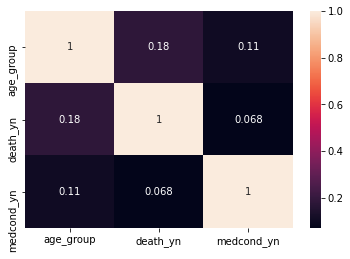

In [44]:
sns.heatmap(sample.corr(), annot = True)
plt.show()

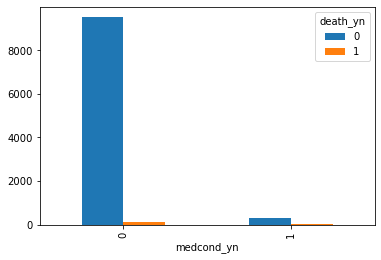

In [45]:
crosstab.plot.bar()
plt.show()

In [46]:
grouped = sample.groupby('medcond_yn').aggregate({'death_yn': np.average})
grouped

,death_yn
medcond_yn,
0,0.010500
1,0.053333


In [47]:
grouped.index == 1

array([False,  True])

In [50]:
medcond_death_rate = grouped.loc[grouped.index == 1, 'death_yn'] * 100
no_medcond_death_rate = grouped.loc[grouped.index == 0, 'death_yn'] * 100
actual_diff = medcond_death_rate.iloc[0] - no_medcond_death_rate.iloc[0]
print(actual_diff.round(4))

4.2833


In [51]:
grouped_age = sample.groupby('age_group').aggregate({'death_yn': np.average})
grouped_age

,death_yn
age_group,
5.0,0.000000
15.0,0.000000
25.0,0.000000
35.0,0.001224
45.0,0.000749
55.0,0.006686
65.0,0.023185
75.0,0.054446
85.0,0.151163


In [52]:
under_60 = sample[sample.age_group < 60]
over_60 = sample[sample.age_group > 60]
print(under_60.shape)
print(over_60.shape)

(8032, 12)
(1887, 12)


### Medical Condition Permutation Test

In [53]:
def perm_fun(df, len_a, len_b, col):
    idx_a = set(df.sample(len_a).index)
    idx_b = set(df.index) - idx_a
    
    return df.loc[df.index.isin(idx_a), col].mean() - df.loc[df.index.isin(idx_b), col].mean()

In [54]:
perm_diffs = [perm_fun(sample, yes_medcond.shape[0], no_medcond.shape[0], 'death_yn') * 100 for _ in range(10000)]

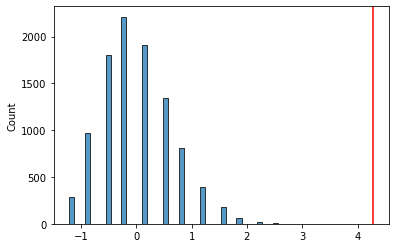

In [55]:
plt.figure()

sns.histplot(data = perm_diffs)
plt.axvline(actual_diff, color = 'red')

plt.show()

In [56]:
p_val = [0 if actual_diff > diff else 1 for diff in perm_diffs]
p_val = np.array(p_val)
p_val.mean()

0.0

### Age Permutation Test

In [57]:
actual_diff = (over_60.death_yn.mean() - under_60.death_yn.mean()) * 100
print(actual_diff)

5.414985526890847


In [58]:
perm_diffs = [perm_fun(sample, over_60.shape[0], under_60.shape[0], 'death_yn') * 100 for _ in range(1000)]

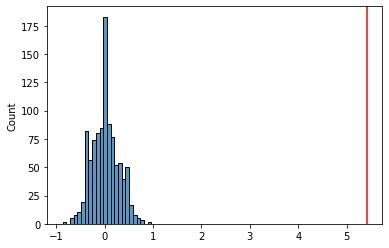

In [59]:
plt.figure()

sns.histplot(data = perm_diffs)
plt.axvline(actual_diff, color = 'red')

plt.show()

In [60]:
p_val = [0 if actual_diff > diff else 1 for diff in perm_diffs]
p_val = np.array(p_val)
p_val.mean()

0.0

In [61]:
def sigmoid(z):
    """
    computes sigmoid of scalar
    """
    sigmoid = 1 / (1 + np.exp(-z))
    
    return sigmoid

In [62]:
def compute_cost_logistic(X, y, w, b):
    """
    args:
        X: feature vector
        y: target vector
        w,b: scalar paremeters
        
    returns:
        cost for given parameters
    """
    
    m = X.shape[0] # number of training examples
    total_cost = 0
    
    for i in range(m):
        z_i = np.dot(X[i], w) + b
        f_wb_i = sigmoid(z_i)
        
        # cost at i
        j_wb_i = y[i] * np.log(f_wb_i) + (1 - y[i]) * np.log(1 - f_wb_i)
        
        total_cost += j_wb_i
        
    total_cost = - (total_cost / m)
    
    return total_cost

In [63]:
def compute_gradient_logistic(X, y, w, b):
    """
    args:
        X: 1darray feature vecotr
        y: 1darray target vector
        w,b: scalar parameters of cost function
        
    returns:
        total loss for parameters w,b
    """
    
    m = X.shape[0] # number of training examples
    dw = 0
    db = 0
    
    for i in range(m):
        z_i = np.dot(X[i], w) + b # dot product of scalars is simply a multiplication
        f_wb_i = sigmoid(z_i)
        
        d_dw_i = (f_wb_i - y[i]) * X[i]
        d_db_i = f_wb_i - y[i]
        
        dw += d_dw_i
        db += d_db_i
        
    dw = dw / m
    db = db / m
    
    return dw, db

In [64]:
def gradient_descent(X, y, w_in, b_in, alpha, iterations):
    """
    args:
        X: feature vectors
        y: target vector
        w_in, b_in: scalar parameters
        alpha: learning rate
        iterations: amount of repetitions
        
    returns:
        parameters of the minimized cost function
    """
    
    J_history = []
    w = w_in
    b = b_in
    
    for i in range(iterations):
        dw, db = compute_gradient_logistic(X, y, w, b)
        
        w = w - alpha * dw
        b = b - alpha * db
        
        
        cost = compute_cost_logistic(X, y, w, b)
        
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( compute_cost_logistic(X, y, w, b) )

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i % math.ceil(iterations / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")
        
    return w, b, J_history         #return final w,b and J history for graphing

In [65]:
X_train = np.array(sample.age_group).reshape(-1,1)
y_train = np.array(sample.death_yn).reshape(-1,1)

w = 1
b = 1
alpha = 0.1
iterations = 50

w_out, b_out, _ = gradient_descent(X_train, y_train, w, b, alpha, iterations)

Iteration    0: Cost [2.51895252]   
Iteration    5: Cost [2.12756792]   
Iteration   10: Cost [1.73619759]   
Iteration   15: Cost [1.34495825]   
Iteration   20: Cost [0.95491196]   
Iteration   25: Cost [0.57507045]   
Iteration   30: Cost [0.26403662]   
Iteration   35: Cost [0.22295936]   
Iteration   40: Cost [0.22082827]   
Iteration   45: Cost [0.21872811]   


In [66]:
w_out, b_out

(array([-0.14847309]), array([0.80981893]))

### Multiple Logistic Regression

In [67]:
def compute_ml_cost(x, y, w, b):
    """
    args:
        x: vector of feature variables
        y: vector of feature variables
        w: vector of scalars
        b: scalar parameter
        
    output:
        total cost associated with model parameters w,b
    """
    
    m = x.shape[0]
    total_cost = 0
    
    for i in range(m):
        z_i = np.dot(w, x[i]) + b
        f_wb_i = sigmoid(z_i)
        
        # cost at i
        j_wb_i = y[i] * np.log(f_wb_i) + (1 - y[i]) * np.log(1 - f_wb_i)
        
        total_cost = total_cost + j_wb_i
        
    total_cost = - (total_cost / m)
    
    return total_cost

In [68]:
def compute_ml_gradient(x, y, w, b):
    """
    args:
        x: vector of feature variables
        y: vector of feature variables
        w: vector of scalars
        b: scalar parameter
    """
    
    m,n = x.shape
    
    dj_dw = np.zeros((n,))
    dj_db = 0
    
    for i in range(m):
        z_i = np.dot(w, x[i]) + b
        f_wb_i = sigmoid(z_i)
        
        for j in range(n):
            dj_dw[j] = dj_dw[j] + ((f_wb_i - y[i]) * x[i, j])
            
        dj_db += (f_wb_i - y[i])
        
    dj_dw = dj_dw / m
    dj_db = dj_db / m
    
    return dj_dw, dj_db

In [69]:
def gradient_descent_ml(x, y, w_in, b_in, alpha, iterations):
    """
    args:
        x: 2d vector of feature variables
        y: vector of target variable
        w_in: parameter vector
        b_in: scalar parameter
        alpha: scalar learning rate
        iterations: num of iterations for gd alg
        
    output:
        w,b: parameters for model
        cost: total cost for w,b
    """
    J_history = []
    w = copy.deepcopy(w_in)
    b = b_in
    
    for i in range(iterations):
        dj_dw, dj_db = compute_ml_gradient(x, y, w, b)
            
        w = w - alpha * dj_dw
        b = b - alpha * dj_db
        
        # Save cost J at each iteration
        if (i<100000):      # prevent resource exhaustion 
            J_history.append( compute_ml_cost(x, y, w, b))        
        
        if (i% math.ceil(iterations / 10) == 0):
            print(f"Iteration {i}: Cost {J_history[-1]}   ")
        
    return w, b, J_history #return final w,b and J history for graphing

In [72]:
X_train

array([[25.,  0.],
       [45.,  0.],
       [15.,  0.],
       ...,
       [65.,  0.],
       [25.,  0.],
       [65.,  0.]])

In [70]:
predictors = ['age_group', 'medcond_yn']
X_train = np.array(sample[predictors])
y_train = np.array(sample['death_yn']).reshape(-1,1)

w = np.array([3,2])
b = 1
alpha = 0.1
iterations = 100

w_out, b_out, _ = gradient_descent_ml(X_train, y_train, w, b, alpha, iterations)

Iteration 0: Cost [0.74918958]   
Iteration 10: Cost [0.22213755]   
Iteration 20: Cost [0.21791385]   
Iteration 30: Cost [0.21384524]   
Iteration 40: Cost [0.20989565]   
Iteration 50: Cost [0.20606275]   
Iteration 60: Cost [0.20234412]   
Iteration 70: Cost [0.19873723]   
Iteration 80: Cost [0.19523951]   
Iteration 90: Cost [0.19184832]   


In [71]:
w_out, b_out

(array([-0.12885969,  1.98960586]), array([0.34699974]))